# Stochastic Differential Equations (SDEs)

- [Wikipedia: Stochastic Differential Equations](https://en.wikipedia.org/wiki/Stochastic_differential_equation)
- [SDE example](https://diffeq.sciml.ai/stable/tutorials/sde_example/)
- [RODE example](https://diffeq.sciml.ai/stable/tutorials/rode_example/)

## Stochastic Differential Equations (SDEs)

- Recommended SDE solvers: https://docs.sciml.ai/DiffEqDocs/stable/solvers/sde_solve/

### Scalar SDEs with one state variable

Solving the equation: $du=f(u,p,t)dt + g(u,p,t)dW$

- $f(u,p,t)$ is the ordinary differential equations (ODEs) part
- $g(u,p,t)$ is the stochastic part, paired with a Brownian motion term $dW$.

In [1]:
using StochasticDiffEq
using Plots

ODE function

In [2]:
f = (u, p, t) -> p.α * u

#1 (generic function with 1 method)

Noise term

In [3]:
g = (u, p, t) -> p.β * u

#3 (generic function with 1 method)

Setup the SDE problem

In [4]:
p = (α=1, β=1)
u0 = 1 / 2
dt = 1 // 2^(4)
tspan = (0.0, 1.0)
prob = SDEProblem(f, g, u0, (0.0, 1.0), p)

SDEProblem with uType Float64 and tType Float64. In-place: false
Non-trivial mass matrix: false
timespan: (0.0, 1.0)
u0: 0.5

Use the classic Euler-Maruyama algorithm to solve the problem

In [5]:
sol = solve(prob, EM(), dt=dt)

retcode: Success
Interpolation: 1st order linear
t: 17-element Vector{Float64}:
 0.0
 0.0625
 0.125
 0.1875
 0.25
 0.3125
 0.375
 0.4375
 0.5
 0.5625
 0.625
 0.6875
 0.75
 0.8125
 0.875
 0.9375
 1.0
u: 17-element Vector{Float64}:
 0.5
 0.4060141951150904
 0.4101897966898335
 0.2256598988116713
 0.20874660426723934
 0.17813737710215408
 0.14856604429004105
 0.21730900729349048
 0.23952888756391175
 0.1489098725630178
 0.1543256690094215
 0.12554770558240397
 0.1208157193443121
 0.0961428560066162
 0.07777383657359958
 0.08163501836437098
 0.08709107299710533

Visualize

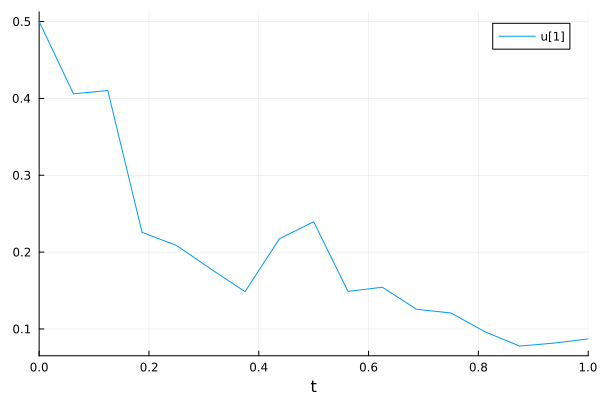

In [6]:
plot(sol)

The analytical solution: If $f(u,p,t) = \alpha u$ and $g(u,p,t) = \beta u$, the analytical solution is $u(t, W_t) = u_0 exp((\alpha - \frac{\beta^2}{2})t + \beta W_t)$

In [7]:
f_analytic = (u0, p, t, W) -> u0 * exp((p.α - (p.β^2) / 2) * t + p.β * W)
ff = SDEFunction(f, g, analytic=f_analytic)
prob = SDEProblem(ff, g, u0, (0.0, 1.0), p)

SDEProblem with uType Float64 and tType Float64. In-place: false
Non-trivial mass matrix: false
timespan: (0.0, 1.0)
u0: 0.5

Visualize numerical and analytical solutions

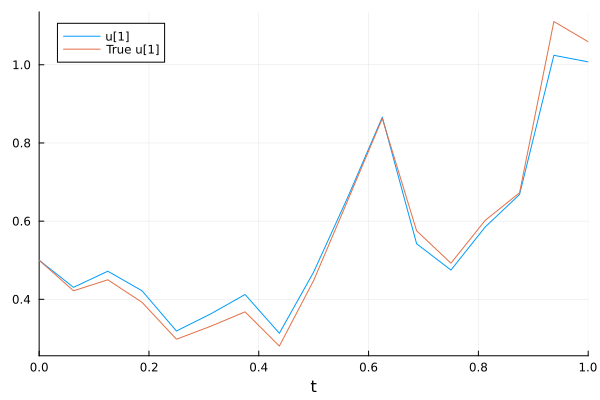

In [8]:
sol = solve(prob, EM(), dt=dt)
plot(sol, plot_analytic=true)

Use a higher-order adaptive solver `SRIW1()` for a more accurate result

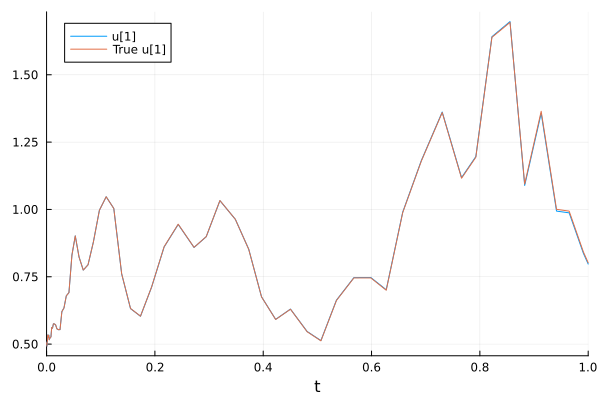

In [9]:
sol = solve(prob, SRIW1())
plot(sol, plot_analytic=true)

### SDEs with diagonal Noise
Each state variable are influenced by its own noise. Here we use the Lorenz system with noise as an example.

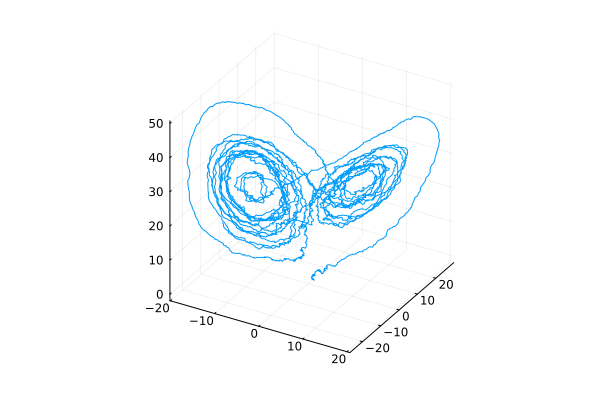

In [10]:
using StochasticDiffEq
using Plots

function lorenz!(du, u, p, t)
    du[1] = 10.0(u[2] - u[1])
    du[2] = u[1] * (28.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - (8 / 3) * u[3]
end

function σ_lorenz!(du, u, p, t)
    du[1] = 3.0
    du[2] = 3.0
    du[3] = 3.0
end

prob_sde_lorenz = SDEProblem(lorenz!, σ_lorenz!, [1.0, 0.0, 0.0], (0.0, 20.0))
sol = solve(prob_sde_lorenz, SRIW1())
plot(sol, idxs=(1, 2, 3), label=false)

### SDEs with scalar Noise
The same noise process (`W`) is applied to all state variables.

In [11]:
using StochasticDiffEq
using DiffEqNoiseProcess: WienerProcess
using Plots

Exponential growth with noise

In [12]:
f = (du, u, p, t) -> (du .= u)
g = (du, u, p, t) -> (du .= u)

#9 (generic function with 1 method)

Problem setup

In [13]:
u0 = rand(4, 2)
W = WienerProcess(0.0, 0.0, 0.0)
prob = SDEProblem(f, g, u0, (0.0, 1.0), noise=W)

SDEProblem with uType Matrix{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 1.0)
u0: 4×2 Matrix{Float64}:
 0.0704615  0.656255
 0.740109   0.511136
 0.0120195  0.218462
 0.627732   0.291875

Solve and visualize

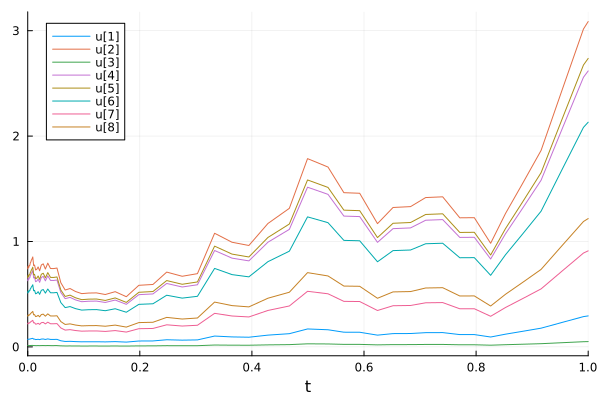

In [14]:
sol = solve(prob, SRIW1())
plot(sol)

### SDEs with Non-Diagonal (matrix) Noise

A more general type of noise allows for the terms to linearly mixed via noise function `g` being a matrix.

$$
\begin{aligned}
du_1 &= f_1(u,p,t)dt + g_{11}(u,p,t)dW_1 + g_{12}(u,p,t)dW_2 + g_{13}(u,p,t)dW_3 + g_{14}(u,p,t)dW_4  \\
du_2 &= f_2(u,p,t)dt + g_{21}(u,p,t)dW_1 + g_{22}(u,p,t)dW_2 + g_{23}(u,p,t)dW_3 + g_{24}(u,p,t)dW_4
\end{aligned}
$$

In [15]:
using StochasticDiffEq
using Plots

f = (du, u, p, t) -> du .= 1.01u

g = (du, u, p, t) -> begin
    du[1, 1] = 0.3u[1]
    du[1, 2] = 0.6u[1]
    du[1, 3] = 0.9u[1]
    du[1, 4] = 0.12u[1]
    du[2, 1] = 1.2u[2]
    du[2, 2] = 0.2u[2]
    du[2, 3] = 0.3u[2]
    du[2, 4] = 1.8u[2]
end

u0 = ones(2)
tspan = (0.0, 1.0)

(0.0, 1.0)

The noise matrix itself is determined by the keyword argument noise_rate_prototype

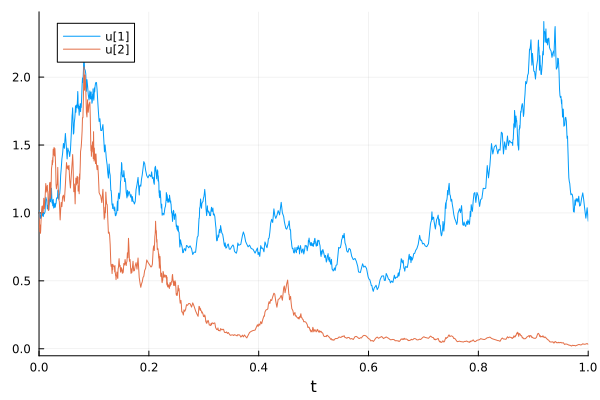

In [16]:
prob = SDEProblem(f, g, u0, tspan, noise_rate_prototype=zeros(2, 4))
sol = solve(prob, LambaEulerHeun())
plot(sol)

### Random ODEs

https://docs.sciml.ai/DiffEqDocs/stable/tutorials/rode_example/

Random ODEs (RODEs) is a more general form that allows nonlinear mixings of randomness.

$du = f(u, p, t, W) dt$ where $W(t)$ is a Wiener process (Gaussian process).

`RODEProblem(f, u0, tspan [, params])` constructs an RODE problem.

The model function signature is
- `f(u, p, t, W)` (out-of-place form).
- `f(du, u, p, t, W)` (in-place form).

In [17]:
using StochasticDiffEq
using Plots

Scalar RODEs

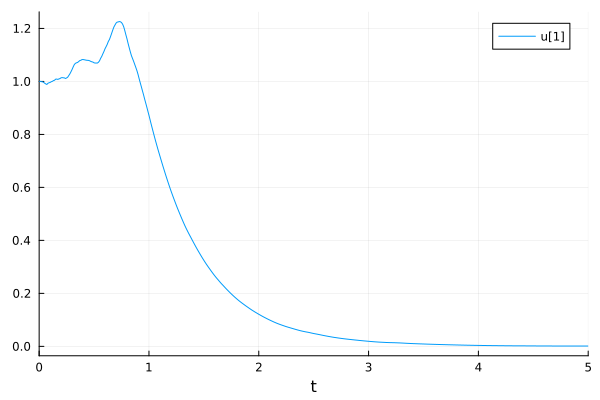

In [18]:
u0 = 1.00
tspan = (0.0, 5.0)
prob = RODEProblem((u, p, t, W) -> 2u * sin(W), u0, tspan)
sol = solve(prob, RandomEM(), dt=1 / 100)
plot(sol)

Systems of RODEs

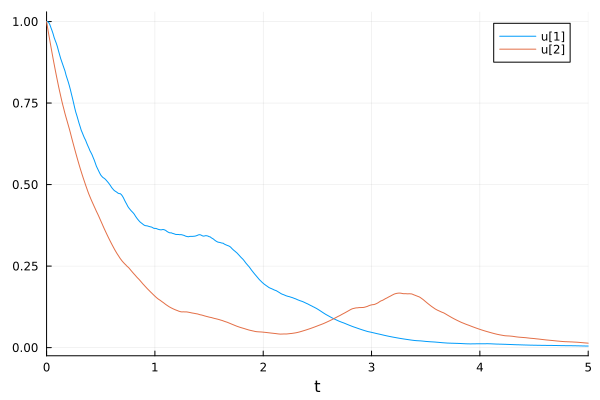

In [19]:
function f4(du, u, p, t, W)
    du[1] = 2u[1] * sin(W[1] - W[2])
    du[2] = -2u[2] * cos(W[1] + W[2])
end

u0 = [1.00; 1.00]
tspan = (0.0, 5.0)

prob = RODEProblem(f4, u0, tspan)
sol = solve(prob, RandomEM(), dt=1 / 100)
plot(sol)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*